<a href="https://colab.research.google.com/github/Kraken2003/LegalDoc_genAI/blob/main/Clause__Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 79.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.2 MB/s eta 0:00:00


In [ ]:
#importing relevant dependencies for the task in hand
import os
import re
import spacy
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch
import numpy as np

In [ ]:
#Using spacy's english language model and stop words
nlp = spacy.load("en_core_web_sm")
from spacy.lang.en.stop_words import STOP_WORDS

In [ ]:
def extract_clauses(txt_filename):
  """
    Extracts and compiles legal clauses from a text file based on the specific regex pattern.

    Args:
        txt_filename (str): The name of the plain text file to extract clauses from.

    Returns:
        str: A string containing the compiled legal clauses from the plain text file.
    """

  clause_pattern = re.compile(r'(?<=\n)(\d+(\.\d+)*[.)])\s*((?:(?!\n\d+(\.\d+)*[.)]|\n\d+\s*;)[\s\S])*)', re.MULTILINE)  #This regex expression is used to catch all possible clauses
  with open(txt_filename,'r') as file:
    txt_file_content = file.read()
    clause_text = re.findall(clause_pattern,txt_file_content)
    file.close()

  content_list = []
  for item in clause_text:
    for sentences in item[1:]:  #Omiting the initial number with which the clause begins from
      if sentences.strip():
        content_list.append(sentences)
  clause_text_string = ""
  for position in range(len(content_list)):
    clause_text_string  = " ".join(content_list)

  return clause_text_string


In [ ]:
def clean_and_tokenize(filename):
  """
    Cleans and tokenizes the filename of the plain text file using spaCy.

    Args:
        filename (str): The name of the file to be cleaned and tokenized.

    Returns:
        str: A string containing cleaned and tokenized filename.
    """

    doc_spacy = nlp(filename)
    tokens = [
        token.text.lower() for token in doc_spacy
        if not token.text.isdigit() and token.text.lower() not in STOP_WORDS
        and token.text not in ("(", ")", "-", ";")
    ]
    return " ".join(tokens)

# Directory containing all the text files (this drive link will be available for view in the README file of this GitHub repo)
txt_folder = r'/content/drive/MyDrive/mike legal task/training txt files'

data = [] #Data list to be used for creating a dataframe

for filename in os.listdir(txt_folder):
  if filename.endswith(".txt"):
    try:
      clauses = extract_clauses(os.path.join(txt_folder, filename))
      cleaned_filename = clean_and_tokenize(filename[:-4])
      data.append({'filename': cleaned_filename, 'clause': clauses})
    except:
      print("could not do", filename)


In [ ]:
# Creating a DataFrame from the data
df = pd.DataFrame(data)
df

,filename,clause
0,20201104_tui_investment_commitment_agreement f...,DEFINITIONS AND INTERPRETATION\t5 COMMITMENT\t...
1,20201028_myttech_employmentagreement,DEFINITIONS AND INTERPRETATION\t4 EMPLOYMENT\t...
2,20201023_gg_loan agreement,The Borrower is engaged in the business of agr...
3,demo joint venture agreement,DEFINITIONS AND INTERPRETATION\t4 EFFECTIVE DA...
4,contract sale goods seller friendly version,Sale of Goods. The Seller shall sell to the Bu...
5,draft sha_belita_11082015_clean_execution version,Definitions and Interpretations\n .1 Definitio...
6,example shareholder agreement,Definitions\nIn this agreement the following d...
7,llc operating agreement,"1 Formation On, [DATE COMPANY FORMED], the C..."
8,rental agreement plain language lease,PARTIES: This agreement is entered into on thi...
9,offer letter- aatmnirbhar final,Date of Joining: You’re required to join the C...


In [ ]:
def get_sentences(raw_text):
  """
    Splits raw text into sentences using spaCy.

    Args:
        raw_text (str): The raw text to be split into sentences.

    Returns:
        list of str: A list containing individual sentences extracted from the raw text.
    """

  preprocessed_text = re.sub(r'[^a-zA-Z0-9\. ]+', ' ', raw_text)  # Using another regex expression for gathering all alphanumeric information
  doc_spacy = nlp(preprocessed_text)
  sentences = [sent.text for sent in doc_spacy.sents]
  return sentences

#tokenization and cleaning
df['preprocessed_clause'] = df['clause'].apply(lambda x: get_sentences(x))

In [ ]:
def remove_stop_words_and_digits(sentence_list):
  """
    Removes stop words and digits from a list of sentences using spaCy.

    Args:
        sentence_list (list of str): A list containing sentences to be cleaned.

    Returns:
        list of str: A list containing cleaned sentences with stop words and digits removed.
    """

    cleaned_sentences = []

    for sentence in sentence_list:
        doc = nlp(sentence)
        cleaned_tokens = [
            token.text for token in doc
            if not token.is_stop and not token.text.isdigit()
        ]
        cleaned_sentence = ' '.join(cleaned_tokens)
        cleaned_sentences.append(cleaned_sentence)

    return cleaned_sentences

#Another process of tokenization and cleaning
df['cleaned_text'] = df['preprocessed_clause'].apply(remove_stop_words_and_digits)


In [ ]:
df.to_csv(r'/content/drive/MyDrive/mike legal task/tokenized_dataframe.csv', index=False, encoding='utf-8')

In [ ]:
nlp_df = pd.read_csv(r'/content/drive/MyDrive/mike legal task/tokenized_dataframe.csv')

#This particluar file 'consulting agreement- nikhil d' could not pass the regex expression for the clause extraction and hence is an empty row
index_to_remove = 14
nlp_df = nlp_df.drop(index_to_remove)
nlp_df = nlp_df.reset_index(drop=True)

#This is our final dataset
nlp_df.to_csv(r'/content/drive/MyDrive/mike legal task/final_dataframe.csv', index=False)

In [ ]:
new_df = pd.read_csv(r'/content/drive/MyDrive/mike legal task/final_dataframe.csv')
new_df

,filename,clause,preprocessed_clause,cleaned_text
0,20201104_tui_investment_commitment_agreement f...,DEFINITIONS AND INTERPRETATION\t5 COMMITMENT\t...,['DEFINITIONS AND INTERPRETATION 5 COMMITMENT ...,['DEFINITIONS INTERPRETATION COMMITMENT REPRES...
1,20201028_myttech_employmentagreement,DEFINITIONS AND INTERPRETATION\t4 EMPLOYMENT\t...,['DEFINITIONS AND INTERPRETATION 4 EMPLOYMENT ...,['DEFINITIONS INTERPRETATION EMPLOYMENT REMUNE...
2,20201023_gg_loan agreement,The Borrower is engaged in the business of agr...,['The Borrower is engaged in the business of a...,"['Borrower engaged business agriculture . ', ..."
3,demo joint venture agreement,DEFINITIONS AND INTERPRETATION\t4 EFFECTIVE DA...,['DEFINITIONS AND INTERPRETATION 4 EFFECTIVE D...,['DEFINITIONS INTERPRETATION EFFECTIVE DATE IN...
4,contract sale goods seller friendly version,Sale of Goods. The Seller shall sell to the Bu...,"['Sale of Goods.', 'The Seller shall sell to t...","['Sale Goods .', 'Seller shall sell Buyer Buye..."
5,draft sha_belita_11082015_clean_execution version,Definitions and Interpretations\n .1 Definitio...,['Definitions and Interpretations .1 Definiti...,['Definitions Interpretations .1 Definitions...
6,example shareholder agreement,Definitions\nIn this agreement the following d...,['Definitions In this agreement the following ...,['Definitions agreement following definitions ...
7,llc operating agreement,"1 Formation On, [DATE COMPANY FORMED], the C...",['1 Formation On DATE COMPANY FORMED the ...,[' Formation DATE COMPANY FORMED Compan...
8,rental agreement plain language lease,PARTIES: This agreement is entered into on thi...,"['PARTIES ', 'This agreement is entered into ...","['PARTIES ', 'agreement entered date follo..."
9,offer letter- aatmnirbhar final,Date of Joining: You’re required to join the C...,['Date of Joining You re required to join the...,['Date Joining required join Company latest ...


In [ ]:
#Loading the pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name)


def generate_bert_embeddings(text_list):

  """
    Generates BERT embeddings for a list of sentences using a pre-trained BERT model.

    Args:
        text_list (list of str): A list containing sentences for which embeddings will be generated.

    Returns:
        list of tensors: A list of tensors containing BERT embeddings for each sentence in the input list.
    """

  combined_text = ' '.join(text_list)
  #Tokenizing the combined text
  inputs = tokenizer(combined_text, padding=True, truncation=True, return_tensors='pt')

    #Generating BERT embeddings
  with torch.no_grad():
    outputs = bert_model(**inputs)

    # Extracts embeddings for each sentence
  sentence_embeddings = outputs.last_hidden_state.split(len(text_list))
  return sentence_embeddings

#Applying the function to the clauses
new_df['bert_embeddings'] = new_df['cleaned_text'].apply(generate_bert_embeddings)


Cosine Similarity Section

I created embeddings using BERT for the filenames as well and converted all tensors embeddings into numpy arrays.

In [ ]:
for i in range(len(new_df)):
    new_df['bert_embeddings'].loc[i] = new_df['bert_embeddings'].loc[i][0].numpy()


In [ ]:
new_df

,filename,clause,preprocessed_clause,cleaned_text,bert_embeddings
0,20201104_tui_investment_commitment_agreement f...,DEFINITIONS AND INTERPRETATION\t5 COMMITMENT\t...,['DEFINITIONS AND INTERPRETATION 5 COMMITMENT ...,['DEFINITIONS INTERPRETATION COMMITMENT REPRES...,"[[[-0.5963227, 0.9168191, 0.33474627, 0.397321..."
1,20201028_myttech_employmentagreement,DEFINITIONS AND INTERPRETATION\t4 EMPLOYMENT\t...,['DEFINITIONS AND INTERPRETATION 4 EMPLOYMENT ...,['DEFINITIONS INTERPRETATION EMPLOYMENT REMUNE...,"[[[-0.581814, 0.91151935, 0.32992035, 0.414086..."
2,20201023_gg_loan agreement,The Borrower is engaged in the business of agr...,['The Borrower is engaged in the business of a...,"['Borrower engaged business agriculture . ', ...","[[[-0.5879633, 0.9479192, 0.23739134, 0.245327..."
3,demo joint venture agreement,DEFINITIONS AND INTERPRETATION\t4 EFFECTIVE DA...,['DEFINITIONS AND INTERPRETATION 4 EFFECTIVE D...,['DEFINITIONS INTERPRETATION EFFECTIVE DATE IN...,"[[[-0.46336696, 0.95670867, 0.21772121, 0.2846..."
4,contract sale goods seller friendly version,Sale of Goods. The Seller shall sell to the Bu...,"['Sale of Goods.', 'The Seller shall sell to t...","['Sale Goods .', 'Seller shall sell Buyer Buye...","[[[-0.432182, 1.1962516, 0.18554989, -0.062620..."
5,draft sha_belita_11082015_clean_execution version,Definitions and Interpretations\n .1 Definitio...,['Definitions and Interpretations .1 Definiti...,['Definitions Interpretations .1 Definitions...,"[[[-0.5452187, 0.97491765, 0.03732343, 0.21811..."
6,example shareholder agreement,Definitions\nIn this agreement the following d...,['Definitions In this agreement the following ...,['Definitions agreement following definitions ...,"[[[-0.5316584, 0.97993433, 0.23604752, 0.20761..."
7,llc operating agreement,"1 Formation On, [DATE COMPANY FORMED], the C...",['1 Formation On DATE COMPANY FORMED the ...,[' Formation DATE COMPANY FORMED Compan...,"[[[-0.40236363, 1.115782, 0.09805708, 0.183959..."
8,rental agreement plain language lease,PARTIES: This agreement is entered into on thi...,"['PARTIES ', 'This agreement is entered into ...","['PARTIES ', 'agreement entered date follo...","[[[-0.49929252, 0.9817282, 0.15926312, 0.19461..."
9,offer letter- aatmnirbhar final,Date of Joining: You’re required to join the C...,['Date of Joining You re required to join the...,['Date Joining required join Company latest ...,"[[[-0.43522885, 0.97234404, 0.05759322, -0.042..."


In [ ]:
np.save('/content/drive/MyDrive/mike legal task/numpy_clause_embeddings.npy', new_df['bert_embeddings'].to_numpy())

In [ ]:
new_df['filename_embeddings'] = new_df['filename'].apply(generate_bert_embeddings)

In [ ]:
for i in range(len(new_df)):
    new_df['filename_embeddings'].loc[i] = new_df['filename_embeddings'].loc[i][0].numpy()

In [ ]:
np.save('/content/drive/MyDrive/mike legal task/numpy_filename_embeddings.npy', new_df['filename_embeddings'].to_numpy())

In [2]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
ce = np.load('/content/drive/MyDrive/mike legal task/numpy_clause_embeddings.npy', allow_pickle=True)
fe = np.load('/content/drive/MyDrive/mike legal task/numpy_filename_embeddings.npy', allow_pickle=True)

The Cosine Similarity shows that there is indeed similarity between the clauses and their respective filenames.

 The data is also consistent with that and achieves an average similarity of 0.8 accross all the documents.

In [ ]:
def calculate_cosine_similarity(ce, fe):
  """
    Calculate cosine similarity between clause embeddings (ce) and filename embeddings (fe)
    for different index numbers and compute the average similarity.

    Parameters:
    ce (list): List of clause embeddings.
    fe (list): List of filename embeddings.

    Prints cosine similarity values for each index number and the average similarity.
    """

  sm_values = []

  for i in range(14):
      ce_i = np.average(ce[i][0], axis=0)
      fe_i = np.average(fe[i][0], axis=0)
      sm = cosine_similarity([ce_i], [fe_i])
      sm_values.append(sm[0][0])
      print(f"File {i}: Cosine Similarity = {sm[0][0]}")

  average_sm = np.mean(sm_values)
  print(f"\nAverage Cosine Similarity: {average_sm}")

calculate_cosine_similarity(ce, fe)

File 0: Cosine Similarity = 0.8040115833282471
File 1: Cosine Similarity = 0.7674633264541626
File 2: Cosine Similarity = 0.7097400426864624
File 3: Cosine Similarity = 0.8240416646003723
File 4: Cosine Similarity = 0.8719471096992493
File 5: Cosine Similarity = 0.7742007970809937
File 6: Cosine Similarity = 0.8299886584281921
File 7: Cosine Similarity = 0.8313055038452148
File 8: Cosine Similarity = 0.8597502708435059
File 9: Cosine Similarity = 0.8264002203941345
File 10: Cosine Similarity = 0.6820266842842102
File 11: Cosine Similarity = 0.898449182510376
File 12: Cosine Similarity = 0.8134003281593323
File 13: Cosine Similarity = 0.7524155378341675

Average Cosine Similarity: 0.8032243847846985


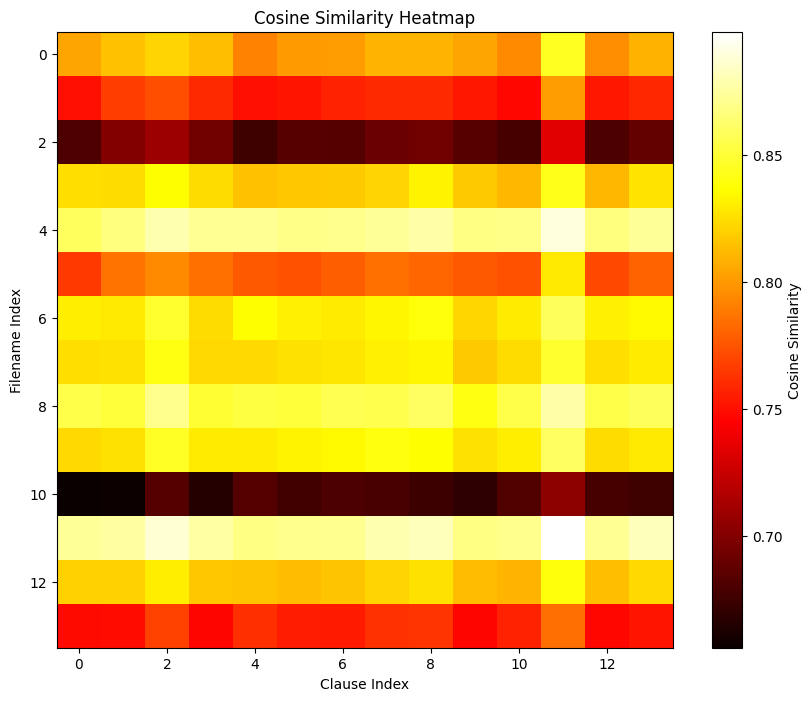

In [ ]:
import matplotlib.pyplot as plt

def calculate_cosine_similarity(ce, fe):
    """
    Calculate cosine similarity between clause embeddings (ce) and filename embeddings (fe)
    for different index numbers and visualize the similarity using a heatmap.

    Parameters:
    ce (list): List of clause embeddings.
    fe (list): List of filename embeddings.
    """

    similarity_matrix = np.zeros((14, 14))

    for fe_idx in range(14):
        fe_i = np.average(fe[fe_idx][0], axis=0)

        for ce_idx in range(14):
            ce_i = np.average(ce[ce_idx][0], axis=0)
            sm = cosine_similarity([fe_i], [ce_i])
            similarity_matrix[fe_idx, ce_idx] = sm[0][0]

    plt.figure(figsize=(10, 8))
    plt.imshow(similarity_matrix, cmap='hot', interpolation='nearest')
    plt.colorbar(label='Cosine Similarity')
    plt.xlabel('Clause Index')
    plt.ylabel('Filename Index')
    plt.title('Cosine Similarity Heatmap')
    plt.show()



calculate_cosine_similarity(ce, fe)